In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import snap
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain  # For community detection
import matplotlib.cm as cm

In [12]:
# Load the retweet network with possible edge weights
def load_retweet_network(file_path):
    graph = snap.TNEANet.New()
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            userA, userB = int(parts[0]), int(parts[1])
            weight = int(parts[2]) if len(parts) > 2 else 1
            if not graph.IsNode(userA):
                graph.AddNode(userA)
            if not graph.IsNode(userB):
                graph.AddNode(userB)
            graph.AddEdge(userA, userB)
            edge_id = graph.GetEId(userA, userB)
            graph.AddFltAttrDatE(edge_id, weight, "weight")
    return graph

In [13]:
# Load the retweet network
file_path = 'data/higgs-retweet_network.edgelist'
retweet_network = load_retweet_network(file_path)

In [14]:
# Print network statistics
def print_graph_stats(graph, name):
    print(f"{name} Network:")
    print(f"  Nodes: {graph.GetNodes()}")
    print(f"  Edges: {graph.GetEdges()}")
    WccV = snap.TIntPrV()
    snap.GetWccSzCnt(graph, WccV)
    print(f"  Number of Weakly Connected Components: {len(WccV)}")
    max_diameter = snap.GetBfsFullDiam(graph, 100, False)
    print(f"  Diameter (approx): {max_diameter}")
    print()

In [15]:
# Print the complete network statistics
print_graph_stats(retweet_network, "Complete Retweet")

Complete Retweet Network:
  Nodes: 256491
  Edges: 328132
  Number of Weakly Connected Components: 28
  Diameter (approx): 16



In [16]:
# Calculate degree centrality
def get_degree_centrality(graph):
    in_degree = {}
    out_degree = {}
    for NI in graph.Nodes():
        in_degree[NI.GetId()] = NI.GetInDeg()
        out_degree[NI.GetId()] = NI.GetOutDeg()
    return in_degree, out_degree

in_degree_centrality, out_degree_centrality = get_degree_centrality(retweet_network)


In [17]:
# Identify the most influential node by in-degree centrality
most_influential_node = max(in_degree_centrality, key=in_degree_centrality.get)
print(f"Most influential node by in-degree centrality: {most_influential_node}, Centrality: {in_degree_centrality[most_influential_node]}")


Most influential node by in-degree centrality: 88, Centrality: 14060


In [18]:
# Identify top 10 nodes by degree centrality
top_influential_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 influential nodes by in-degree centrality:")
for node, centrality in top_influential_nodes:
    print(f"Node {node}: {centrality}")


Top 10 influential nodes by in-degree centrality:
Node 88: 14060
Node 14454: 6190
Node 677: 5613
Node 1988: 4335
Node 349: 2802
Node 283: 2039
Node 3571: 1980
Node 6948: 1959
Node 14572: 1692
Node 68278: 1689


In [25]:
# Find the largest strongly connected component (SCC)
Sccs = snap.TCnComV()
snap.GetSccs(retweet_network, Sccs)
largest_scc = max(Sccs, key=len)

In [26]:
# Convert largest_scc to TIntV
largest_scc_tintv = snap.TIntV()
for node in largest_scc:
    largest_scc_tintv.Add(node)

In [27]:
# Get the subgraph of the largest SCC
largest_scc_subgraph = snap.GetSubGraph(retweet_network, largest_scc_tintv)

# Print largest SCC statistics
print_graph_stats(largest_scc_subgraph, "Largest SCC Retweet")

Largest SCC Retweet Network:
  Nodes: 984
  Edges: 3850
  Number of Weakly Connected Components: 1
  Diameter (approx): 9



In [28]:
# Generate a sorted list of edges and their weights for diffusion analysis
edge_weights = {}
for edge in retweet_network.Edges():
    weight = retweet_network.GetFltAttrDatE(edge.GetId(), "weight")
    edge_weights[(edge.GetSrcNId(), edge.GetDstNId())] = weight

edges = []
for edge in largest_scc_subgraph.Edges():
    weight = edge_weights.get((edge.GetSrcNId(), edge.GetDstNId()), 1)
    edges.append((edge.GetSrcNId(), edge.GetDstNId(), weight))
edges = sorted(edges, key=lambda x: x[2], reverse=True)

In [29]:
# Simulate diffusion process
def simulate_diffusion(edges):
    adopters = set()
    adoption_times = []
    t = 0
    for src, dst, _ in edges:
        if src not in adopters:
            adopters.add(src)
            adoption_times.append((t, len(adopters)))
        if dst not in adopters:
            adopters.add(dst)
            adoption_times.append((t, len(adopters)))
        t += 1
    return adoption_times

adoption_times = simulate_diffusion(edges)

# Convert adoption times to a DataFrame
adoption_df = pd.DataFrame(adoption_times, columns=['time', 'adopters'])

In [31]:
# Define external influence model (Bass Model)
def external_influence_model(t, P, alpha):
    return P * (1 - np.exp(-alpha * t))

# Fit the external influence model to the data
def fit_external_influence_model(adoption_df):
    t = adoption_df['time'].values
    A_t = adoption_df['adopters'].values
    P = A_t[-1]

    popt, _ = curve_fit(external_influence_model, t, A_t, bounds=(0, [P, 1]))
    P_hat, alpha_hat = popt
    return P_hat, alpha_hat, t, A_t

# Fit the model and plot the results
P_hat, alpha_hat, t, A_t = fit_external_influence_model(adoption_df)


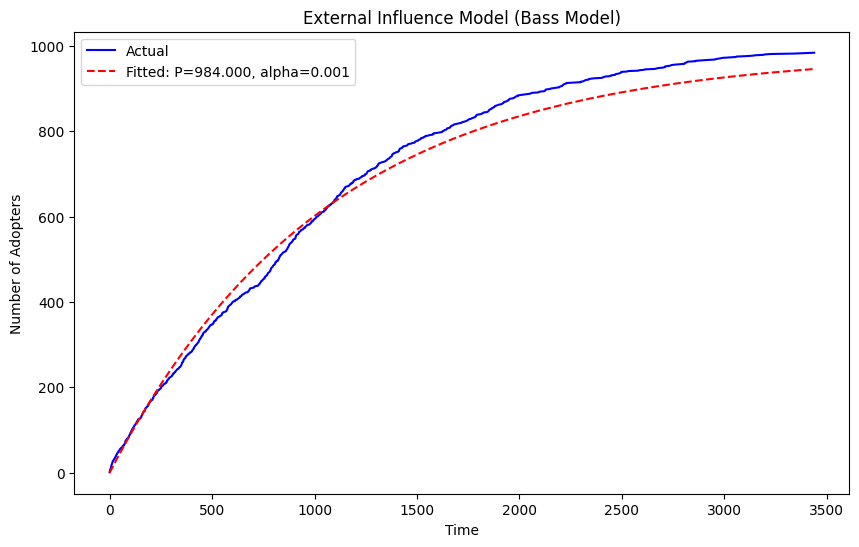

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, A_t, 'b-', label='Actual')
plt.plot(t, external_influence_model(t, P_hat, alpha_hat), 'r--', label=f'Fitted: P={P_hat:.3f}, alpha={alpha_hat:.3f}')
plt.xlabel('Time')
plt.ylabel('Number of Adopters')
plt.title('External Influence Model (Bass Model)')
plt.legend()
plt.show()

In [33]:
# Define internal influence model (Bass Model)
def internal_influence_model(t, P, beta):
    A0 = 1  # Assume initially there is one adopter
    return P / (1 + ((P - A0) / A0) * np.exp(-beta * P * t))

# Fit the internal influence model to the data
def fit_internal_influence_model(adoption_df):
    t = adoption_df['time'].values
    A_t = adoption_df['adopters'].values
    P = A_t[-1]

    popt, _ = curve_fit(internal_influence_model, t, A_t, bounds=(0, [P, 1]))
    P_hat, beta_hat = popt
    return P_hat, beta_hat, t, A_t

# Fit the model and plot the results
P_hat, beta_hat, t, A_t = fit_internal_influence_model(adoption_df)


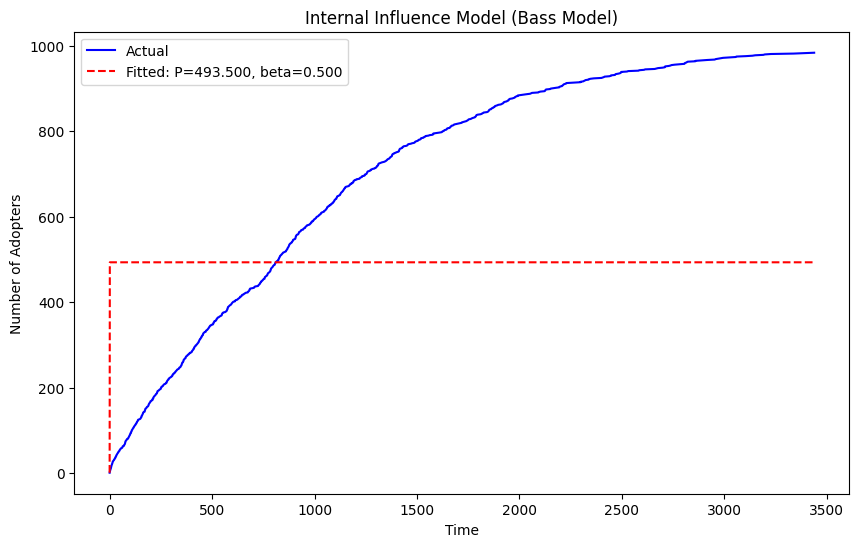

In [34]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, A_t, 'b-', label='Actual')
plt.plot(t, internal_influence_model(t, P_hat, beta_hat), 'r--', label=f'Fitted: P={P_hat:.3f}, beta={beta_hat:.3f}')
plt.xlabel('Time')
plt.ylabel('Number of Adopters')
plt.title('Internal Influence Model (Bass Model)')
plt.legend()
plt.show()

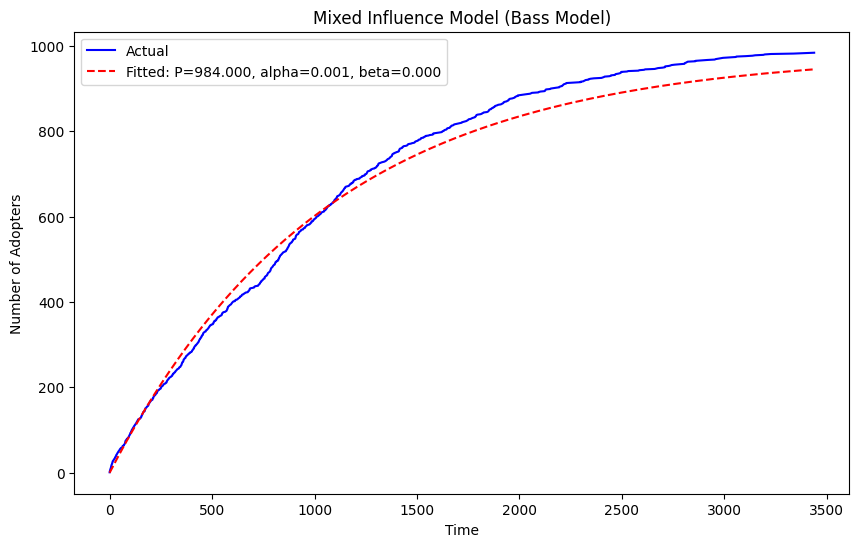

In [35]:
# Define mixed influence model (Bass Model)
def mixed_influence_model(t, P, alpha, beta):
    A0 = 1  # Assume initially there is one adopter
    return ((alpha * (P - A0) / (alpha + beta * A0)) * (1 - np.exp(-(alpha + beta * P) * t)) +
            (beta * (P - A0) / (alpha + beta * A0)) * np.exp(-(alpha + beta * P) * t))

# Fit the mixed influence model to the data
def fit_mixed_influence_model(adoption_df):
    t = adoption_df['time'].values
    A_t = adoption_df['adopters'].values
    P = A_t[-1]

    popt, _ = curve_fit(mixed_influence_model, t, A_t, bounds=(0, [P, 1, 1]))
    P_hat, alpha_hat, beta_hat = popt
    return P_hat, alpha_hat, beta_hat, t, A_t

# Fit the model and plot the results
P_hat, alpha_hat, beta_hat, t, A_t = fit_mixed_influence_model(adoption_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, A_t, 'b-', label='Actual')
plt.plot(t, mixed_influence_model(t, P_hat, alpha_hat, beta_hat), 'r--', label=f'Fitted: P={P_hat:.3f}, alpha={alpha_hat:.3f}, beta={beta_hat:.3f}')
plt.xlabel('Time')
plt.ylabel('Number of Adopters')
plt.title('Mixed Influence Model (Bass Model)')
plt.legend()
plt.show()

In [44]:
# Convert directed graph to undirected for community detection
undirected_graph = snap.ConvertGraph(snap.PUNGraph, largest_scc_subgraph)


In [45]:
# Detect communities using the Louvain method
def detect_communities(graph):
    communities = snap.TCnComV()
    modularity = snap.CommunityCNM(graph, communities)
    return communities, modularity

In [46]:
communities, modularity = detect_communities(undirected_graph)
print(f"Modularity: {modularity}")

Modularity: 0.47093060422571387


In [48]:

# Visualize the network and communities
def plot_communities(graph, communities):
    node_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_community[node] = i

    nx_graph = nx.Graph()
    for node in graph.Nodes():
        nx_graph.add_node(node.GetId())
    for edge in graph.Edges():
        nx_graph.add_edge(edge.GetSrcNId(), edge.GetDstNId())

    colors = [node_community[node] if node in node_community else 0 for node in nx_graph.nodes()]
    pos = nx.spring_layout(nx_graph)
    
    plt.figure(figsize=(12, 12))
    nx.draw(nx_graph, pos, node_color=colors, node_size=50, cmap=plt.cm.viridis, with_labels=False)
    plt.title('Network with Community Structure')
    plt.show()

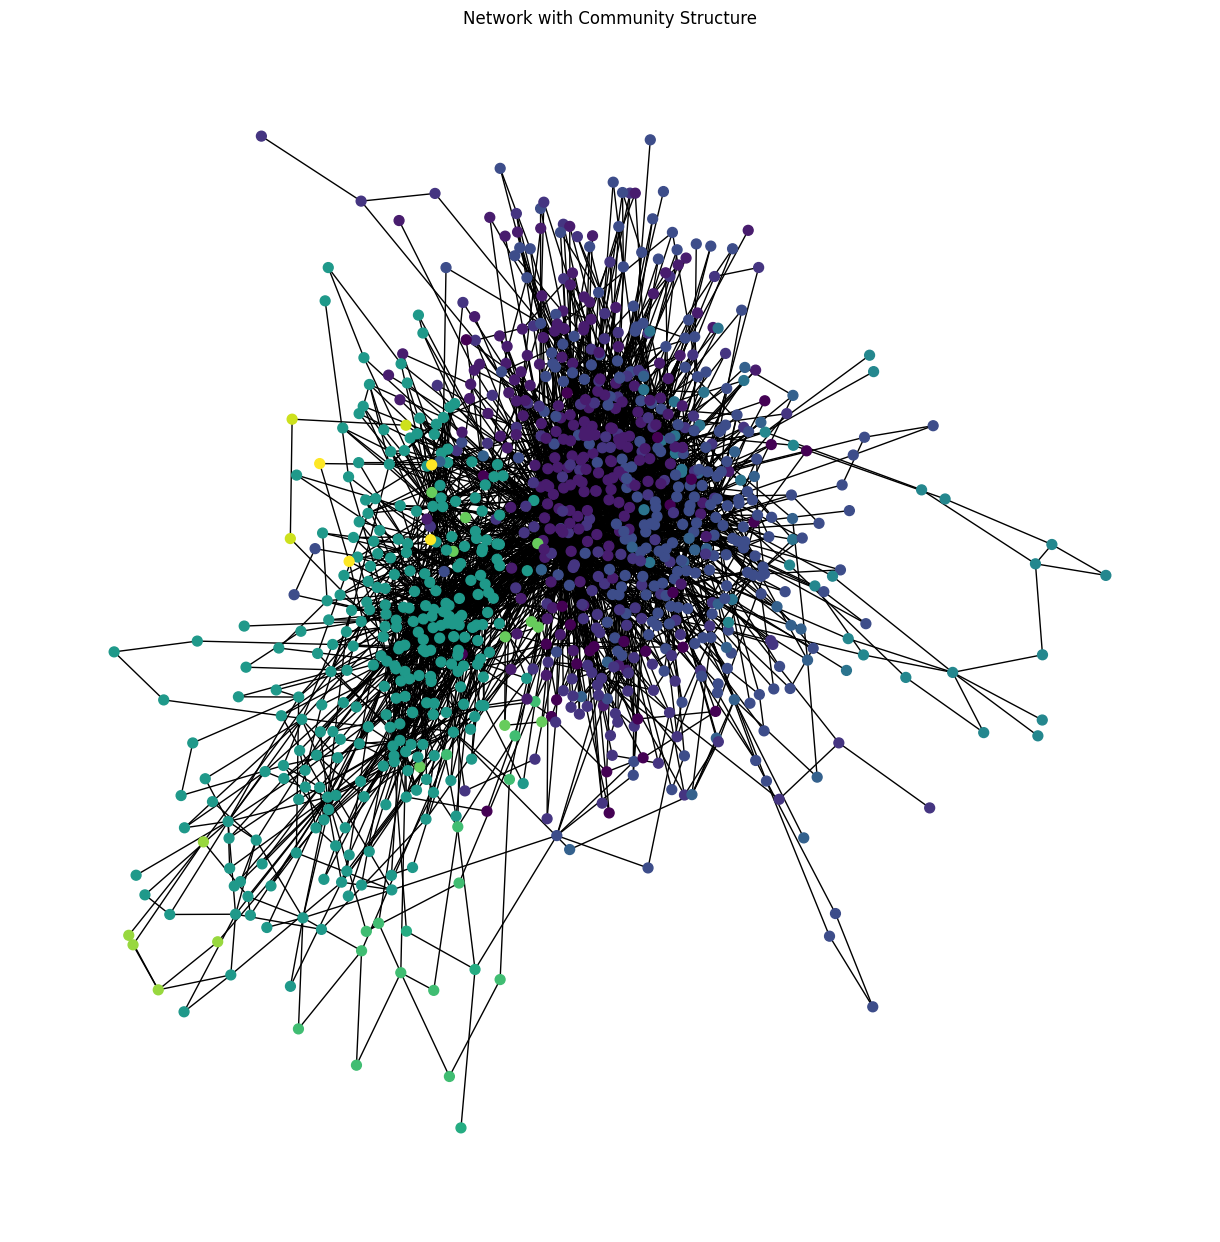

In [49]:
plot_communities(undirected_graph, communities)

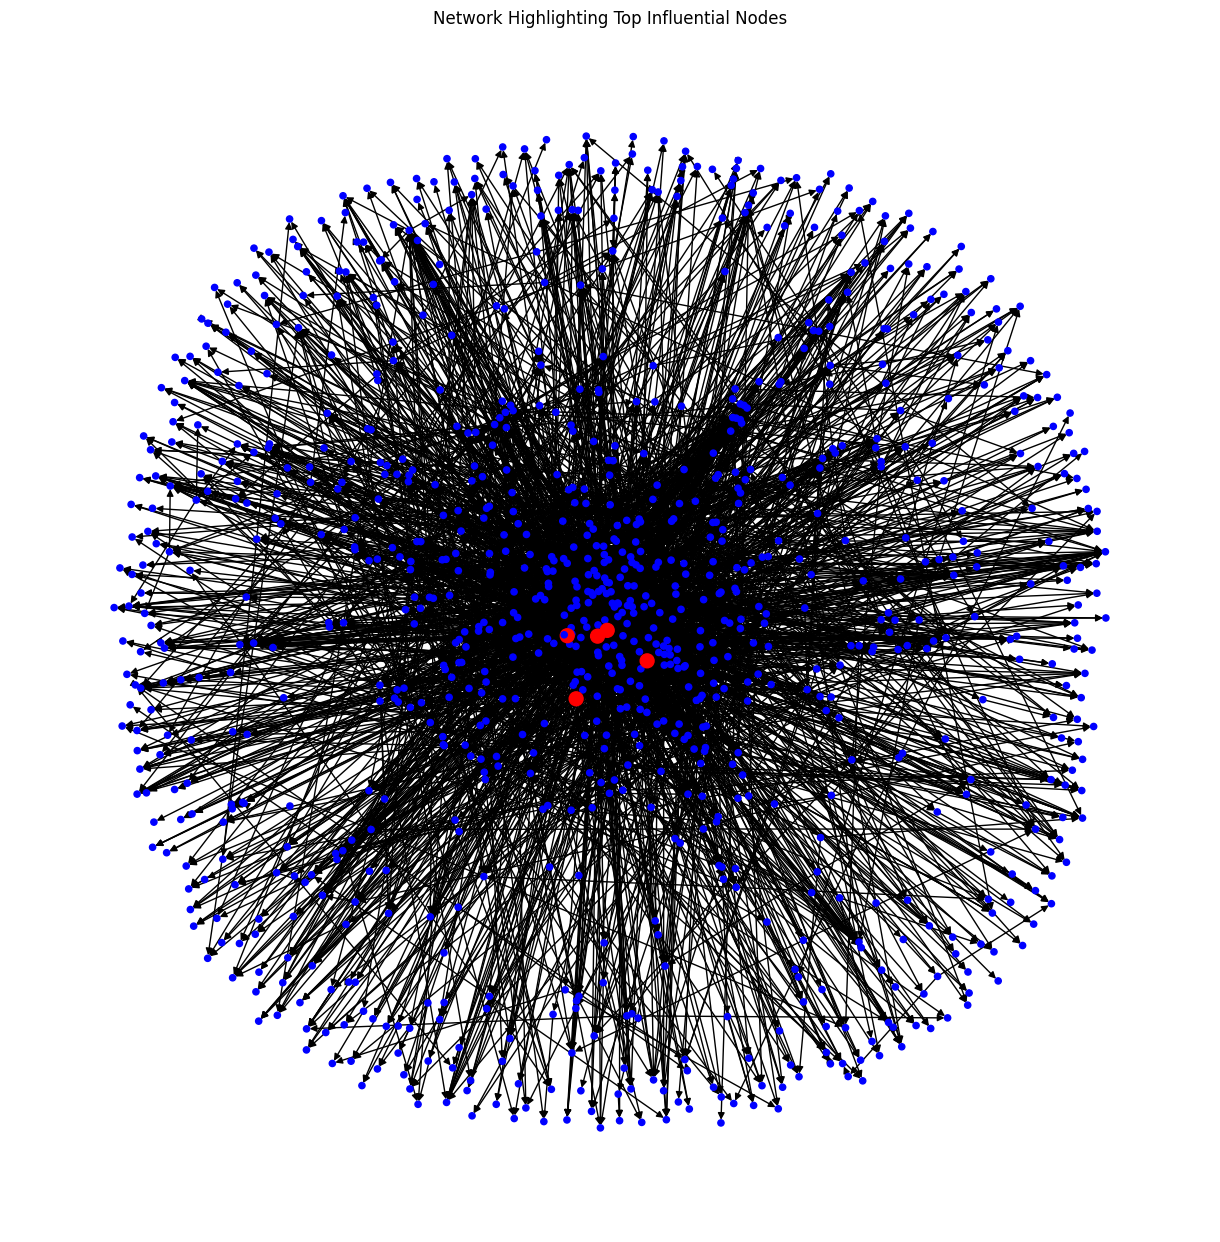

In [50]:
# Draw the network highlighting top influential nodes
def plot_top_influential_nodes(graph, top_nodes):
    nx_graph = nx.DiGraph()
    for node in graph.Nodes():
        nx_graph.add_node(node.GetId())
    for edge in graph.Edges():
        nx_graph.add_edge(edge.GetSrcNId(), edge.GetDstNId())

    pos = nx.spring_layout(nx_graph)
    colors = ['red' if node in top_nodes else 'blue' for node in nx_graph.nodes()]
    sizes = [100 if node in top_nodes else 20 for node in nx_graph.nodes()]

    plt.figure(figsize=(12, 12))
    nx.draw(nx_graph, pos, node_color=colors, node_size=sizes, with_labels=False)
    plt.title('Network Highlighting Top Influential Nodes')
    plt.show()

top_nodes = [node for node, _ in top_influential_nodes]
plot_top_influential_nodes(undirected_graph, top_nodes)

In [58]:
# Obtener tamaños de las comunidades
community_sizes = [len(community) for community in communities]
print(f"Number of communities: {len(communities)}")
print(f"Community sizes: {community_sizes}")

# Identificar influenciadores en cada comunidad
community_influencers = []
for i, community in enumerate(communities):
    community_tintv = snap.TIntV()
    for node in community:
        community_tintv.Add(node)
    community_subgraph = snap.GetSubGraph(retweet_network, community_tintv)
    in_degree_centrality, _ = get_degree_centrality(community_subgraph)
    top_influencer = max(in_degree_centrality, key=in_degree_centrality.get)
    community_influencers.append((i, top_influencer, in_degree_centrality[top_influencer]))

# Ordenar comunidades por la centralidad del influenciador
community_influencers.sort(key=lambda x: x[2], reverse=True)

# Imprimir influenciadores de las comunidades ordenadas por centralidad
for i, top_influencer, centrality in community_influencers:
    community = communities[i]
    print(f"Community {i+1}:")
    print(f"  Size: {len(community)}")
    print(f"  Top Influencer: Node {top_influencer}, In-Degree Centrality: {centrality}")
    print()


Number of communities: 14
Community sizes: [29, 189, 141, 231, 30, 18, 21, 285, 3, 15, 10, 5, 3, 4]
Community 2:
  Size: 189
  Top Influencer: Node 88, In-Degree Centrality: 83

Community 4:
  Size: 231
  Top Influencer: Node 677, In-Degree Centrality: 45

Community 8:
  Size: 285
  Top Influencer: Node 6940, In-Degree Centrality: 45

Community 3:
  Size: 141
  Top Influencer: Node 1988, In-Degree Centrality: 43

Community 5:
  Size: 30
  Top Influencer: Node 3571, In-Degree Centrality: 7

Community 7:
  Size: 21
  Top Influencer: Node 42354, In-Degree Centrality: 5

Community 1:
  Size: 29
  Top Influencer: Node 11692, In-Degree Centrality: 4

Community 11:
  Size: 10
  Top Influencer: Node 42173, In-Degree Centrality: 3

Community 6:
  Size: 18
  Top Influencer: Node 13163, In-Degree Centrality: 2

Community 10:
  Size: 15
  Top Influencer: Node 31086, In-Degree Centrality: 2

Community 12:
  Size: 5
  Top Influencer: Node 39523, In-Degree Centrality: 2

Community 9:
  Size: 3
  Top 

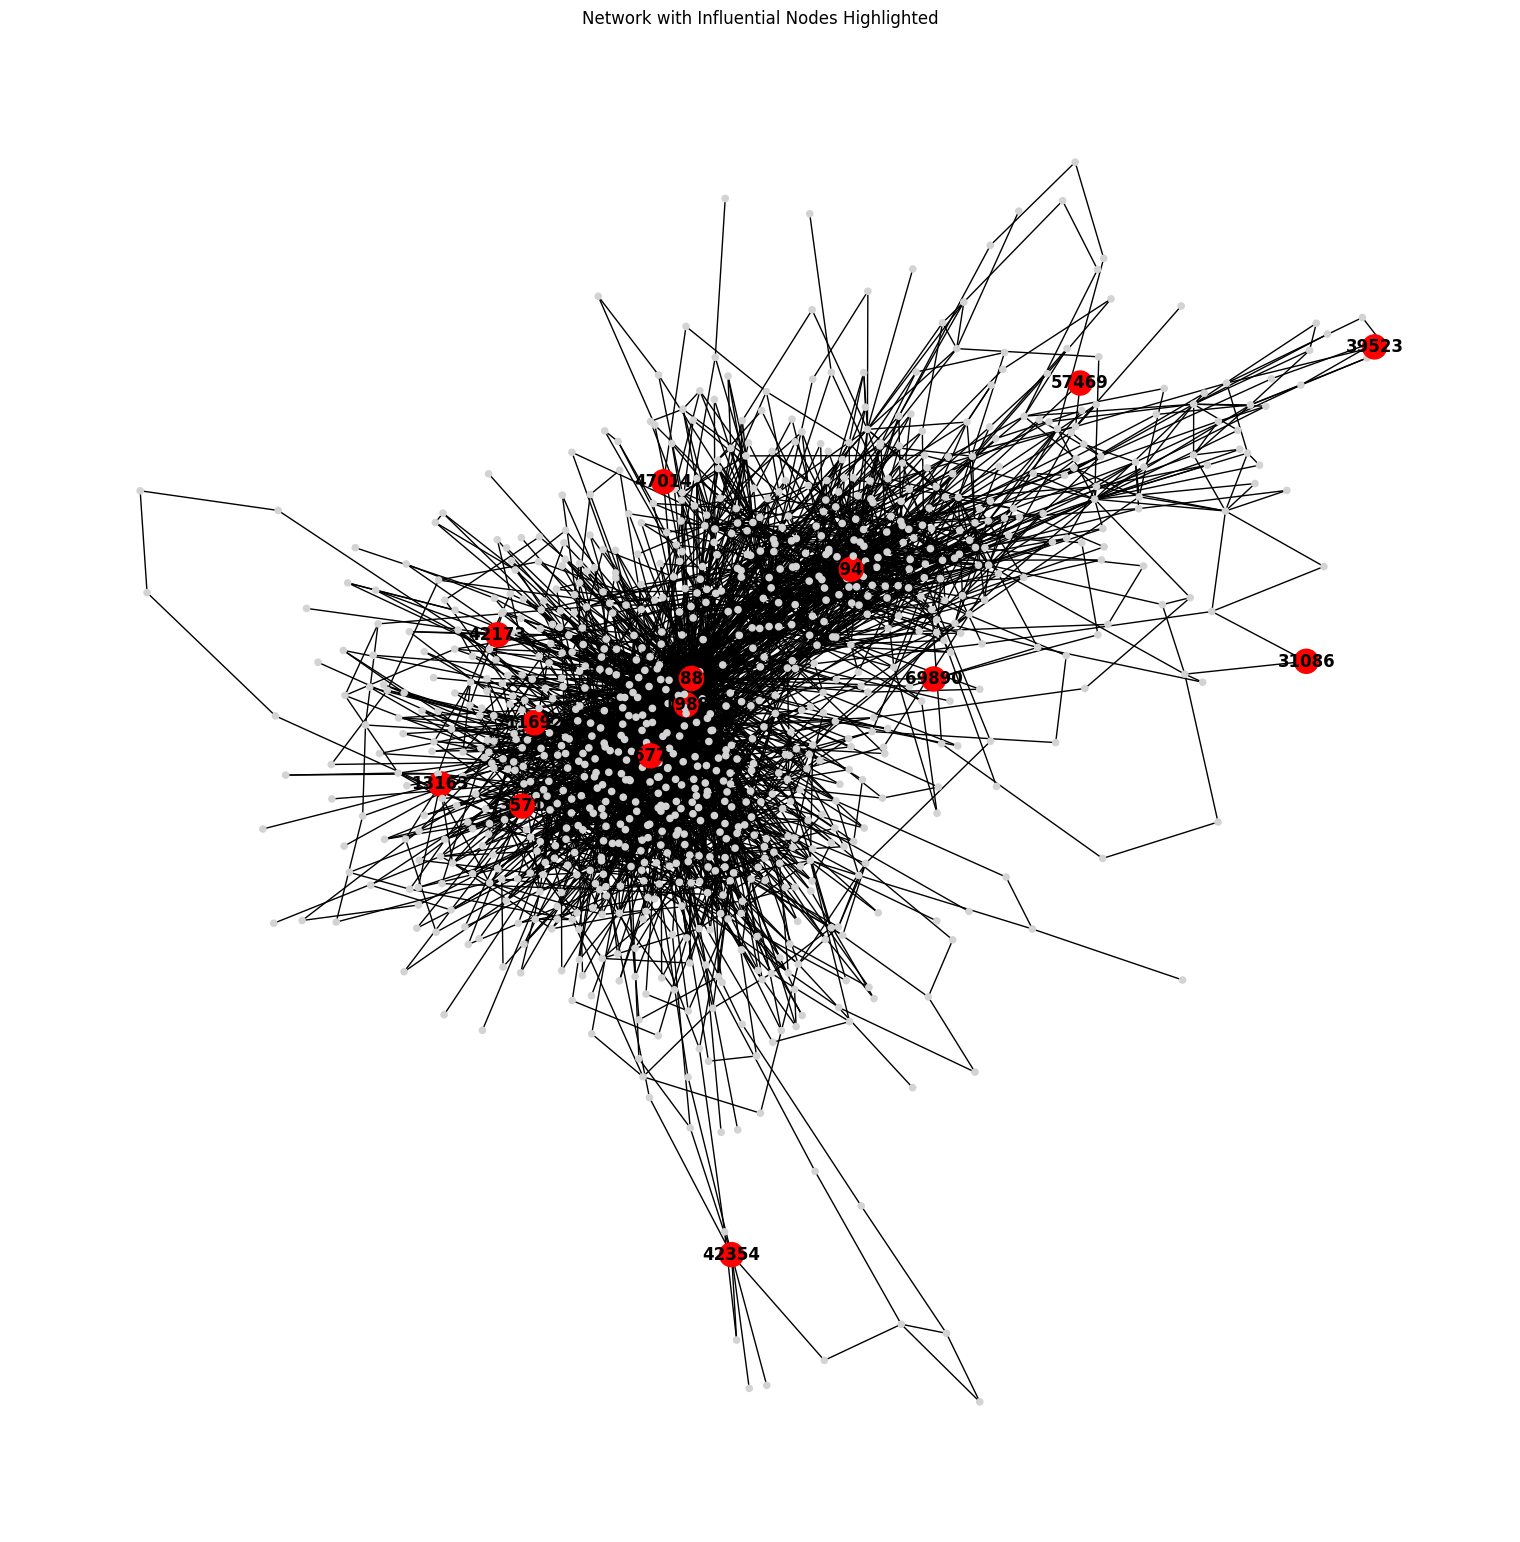

In [54]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to plot communities with influential nodes highlighted and labeled
def plot_communities_with_influencers(graph, communities, top_influencers):
    # Create a networkx graph from the SNAP graph
    nx_graph = nx.Graph()
    for node in graph.Nodes():
        nx_graph.add_node(node.GetId())
    for edge in graph.Edges():
        nx_graph.add_edge(edge.GetSrcNId(), edge.GetDstNId())

    # Assign a community ID to each node
    node_community = {}
    for i, community in enumerate(communities):
        for node in community:
            node_community[node] = i

    # Prepare colors and sizes for plotting
    default_color = 'lightgray'
    default_size = 20
    influencer_color = 'red'
    influencer_size = 300

    colors = [influencer_color if node in top_influencers else default_color for node in nx_graph.nodes()]
    sizes = [influencer_size if node in top_influencers else default_size for node in nx_graph.nodes()]
    labels = {node: str(node) for node in top_influencers}

    # Spring layout for better visualization
    pos = nx.spring_layout(nx_graph)

    plt.figure(figsize=(15, 15))
    nx.draw(nx_graph, pos, node_color=colors, node_size=sizes, cmap=plt.cm.viridis, with_labels=False)
    nx.draw_networkx_labels(nx_graph, pos, labels, font_size=12, font_color='black', font_weight='bold')

    plt.title('Network with Influential Nodes Highlighted')
    plt.show()

# Identify top influencers in each community
top_influencers = []
for i, community in enumerate(communities):
    community_tintv = snap.TIntV()
    for node in community:
        community_tintv.Add(node)
    community_subgraph = snap.GetSubGraph(retweet_network, community_tintv)
    in_degree_centrality, _ = get_degree_centrality(community_subgraph)
    top_influencer = max(in_degree_centrality, key=in_degree_centrality.get)
    top_influencers.append(top_influencer)

# Plot the communities with influential nodes highlighted and labeled
plot_communities_with_influencers(undirected_graph, communities, top_influencers)
